
## ANALYSIS OF RESEARCH PAPERS RELATED TO CORONAVIRUSES - SYMPTOMS



**Importing all necessary libraries and packages**

In [1]:
import numpy as np 
import pandas as pd 
import nltk
nltk.download("stopwords")
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import string
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.cluster import AgglomerativeClustering as AGC

from gensim.models.ldamodel import LdaModel

from sklearn.decomposition import LatentDirichletAllocation as LDA

import gensim
from gensim import corpora, models
# !python -m spacy download en_core_web_sm

!pip install pyldavis

from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
import pyLDAvis.gensim
# import os

try:
    from wordcloud import WordCloud
except:
    !pip install wordcloud
    from wordcloud import WordCloud
    
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from scipy.cluster.hierarchy import ward, dendrogram

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aksha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aksha\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


  Created wheel for pyldavis: filename=pyLDAvis-3.0.0-py2.py3-none-any.whl size=136710 sha256=cba65e83d47a5e9d83ff0b0be81cfcf62cec5917c279020e1c99a6b48a3c93e8
  Stored in directory: c:\users\aksha\appdata\local\pip\cache\wheels\3a\d1\ab\6fcfc953bc60d4f065e5ad7f6a282bb68372a1f92e9b0eb3da
Successfully built pyldavis


You should consider upgrading via the 'c:\users\aksha\anaconda3\python.exe -m pip install --upgrade pip' command.


## 1. Data Cleaning

In [3]:
# load the meta data from the CSV file 
df=pd.read_csv('Data/metadata.csv', usecols=['title','abstract','authors','doi','publish_time'])
print (df.shape)

#drop duplicates
df = df.drop_duplicates(subset='abstract', keep="first")

#drop NANs 
df=df.dropna()

# convert abstracts to lowercase
df["abstract"] = df["abstract"].str.lower()

#show 5 lines of the new dataframe
print (df.shape)
df.head(5)

(45774, 5)
(34809, 5)


,title,doi,abstract,publish_time,authors
0,SIANN: Strain Identification by Alignment to N...,10.1101/001727,next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...
1,Spatial epidemiology of networked metapopulati...,10.1101/003889,an emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li
2,Sequencing of the human IG light chain loci fr...,10.1101/006866,germline variation at immunoglobulin gene (ig)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...
3,Bayesian mixture analysis for metagenomic comm...,10.1101/007476,deep sequencing of clinical samples is now an ...,2014-07-25,Sofia Morfopoulou; Vincent Plagnol
4,Mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,developing methods to reconstruct transmission...,2014-11-11,Stephen P Velsko; Jonathan E Allen


**Stemming -**
Stemming is the process of reducing inflection in words to their root forms such as mapping a group of words to the same stem even if the stem itself is not a valid word in the Language.

**Lemmatization -**
Lemmatization, unlike Stemming, reduces the inflected words properly ensuring that the root word belongs to the language.

As we want our words to be as they are, we will lemmatize them instead of stemming.

In [4]:
stop_words = stopwords.words("english")

punctuation = set(string.punctuation) 
lemmatize = WordNetLemmatizer()

def preprocess(article):
    stop = " ".join([i for i in article.lower().split() if i not in stop_words])
    pun = "".join(i for i in stop if i not in punctuation) # Remove punctuations, if any.
    lemma = " ".join(lemmatize.lemmatize(i) for i in pun.split())
    return lemma

In [5]:
df["abstract"] = df["abstract"].apply(lambda x: preprocess(x))

In [6]:
text_list = [i.split() for i in df["abstract"]]
len(text_list)

34809

Following is a list of symptoms which people show if they have the coronavirus COVID-19.

In [7]:
vocab = ['cold', 'fever', 'cough', 'rhinitis', 'bronchitis', 'bronchiolitis', 'pneumonia', 'diarrhea', 'headache', 'fatigue']


## 2. Data Visualization and Exploratory Analysis

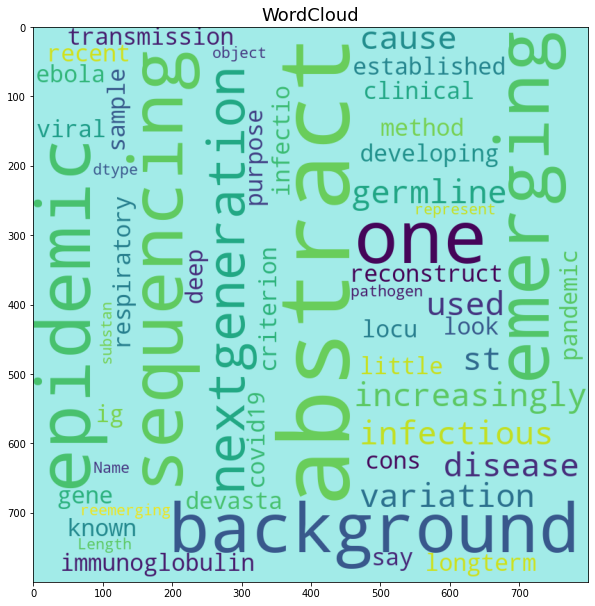

In [8]:
## WordCloud for frequency of words in the entire dataset 

wordcloud = WordCloud(width = 800, height = 800,max_words=100, background_color ='#a2ebe8', min_font_size = 10).generate(str(df["abstract"]))

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("on") 
plt.tight_layout(pad = 0) 
plt.title("WordCloud", fontsize=18)  
plt.show()

The above wordcloud represents the most used words in the reseach papers. We can notice that the words with a bigger font size are the ones which were used often while describing their cases.

In [9]:
# df["abstract"]

In [10]:
cv = CountVectorizer(vocabulary=vocab)
x = cv.fit_transform(df["abstract"])
df_cv = pd.DataFrame(np.round(x.toarray(), 4), columns = cv.get_feature_names())
df_cv.sum().sort_values(ascending=False)

pneumonia        3713
diarrhea         2461
fever            2442
bronchitis        929
cough             788
cold              643
bronchiolitis     567
rhinitis          199
fatigue           120
headache          104
dtype: int64

Text(0, 0.5, 'Count')

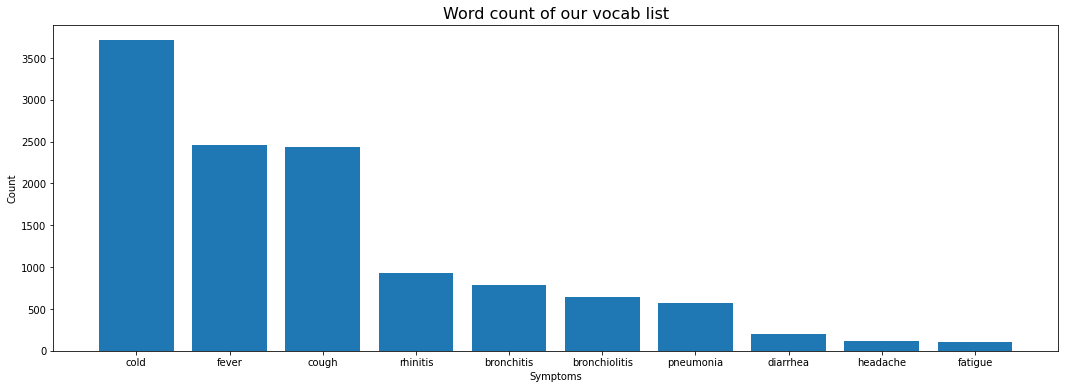

In [11]:
plt.figure(figsize=(18,6))
ylab = df_cv.columns
plt.bar(x=ylab, height= df_cv.sum().sort_values(ascending=False))
plt.title("Word count of our vocab list", fontsize=16)
plt.xlabel("Symptoms")
plt.ylabel("Count")

The bar chart shows the frequency of our vocabulary list in all of our research papers. We can see that the word 'pneumonia' was emphasized the most followed by 'diarrhea' and then 'fever'.

In [12]:
import dateutil.parser as dateparser
def yr(pub):
    dt = dateparser.parse(pub).year
    return dt

In [13]:
df["publish_time"] = df["publish_time"].apply(lambda pub: yr(pub))

In [14]:
years = np.arange(1970, 2021, 1)
total = []
for v in vocab:
    one_word_dict = {}    
    for i in years:
        df1 = df[df['publish_time'] == i]['abstract']
        a = list(map(str, df1.str.contains(v).to_list()))
        b = [j for j in a if j == 'True']
        count = len(b)
        one_word_dict[i] = count
    total.append(one_word_dict)

In [15]:
len(total)

10

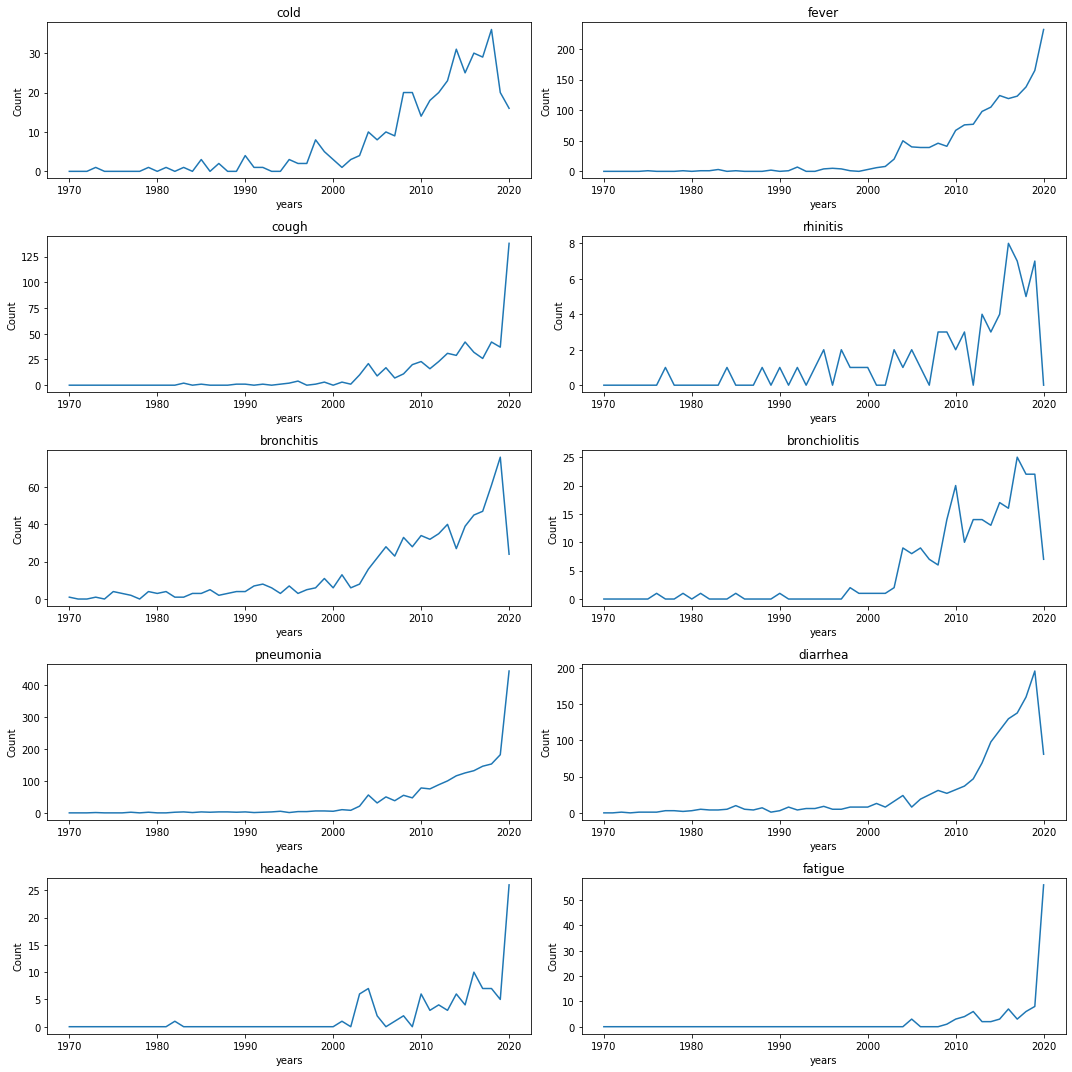

In [17]:
# rand_f_rows = np.asarray(rand.iloc[:,0]) # Selecting country names to assign to the plots below

# rand_f.iloc[i,0:]
fig, axes = plt.subplots(5, 2, figsize=(15,15)) #to define a layout and size of graphs
col = 0
row = 0
i = 0
for row in range(5):
    for col in range (2):
        axes[row, col].plot(years, list(total[i].values()))
        axes[row, col].set_title(vocab[i])
        axes[row, col].set_xlabel('years')
        axes[row, col].set_ylabel('Count')
        i = i+1

plt.tight_layout()
plt.show()

The following time series plots show us the frequency of symptoms as they appear in the research papers every year.

## 3. Model Selection and Implementation

### 3.1 Agglomerative clustering with TF-IDF
**Tf-idf stands for term frequency-inverse document frequency, and the tf-idf weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus.**

**Agglomerative clustering is a type of Hierarchical clustering technique which follows a bottom to top approach in which clusters are made consisting of individual keywords and in the following iterations, they merge until a single parent node has been reached.**

**Here, we will represent the clustering by a dendogram.**

In [15]:
tfidf = TfidfVectorizer(use_idf=False, vocabulary=vocab) # Using only Term frequency

symp_tfidf = tfidf.fit_transform(df["abstract"])

df_symp_tfidf = pd.DataFrame(np.round(symp_tfidf.toarray(), 4), columns = tfidf.get_feature_names())

# These are the unique tokens in our counted tokens, to be used as labels in our other feature matrices
df_symp_tfidf.head()

,cold,fever,cough,rhinitis,bronchitis,bronchiolitis,pneumonia,diarrhea,headache,fatigue
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


C:\Users\Hp\Anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


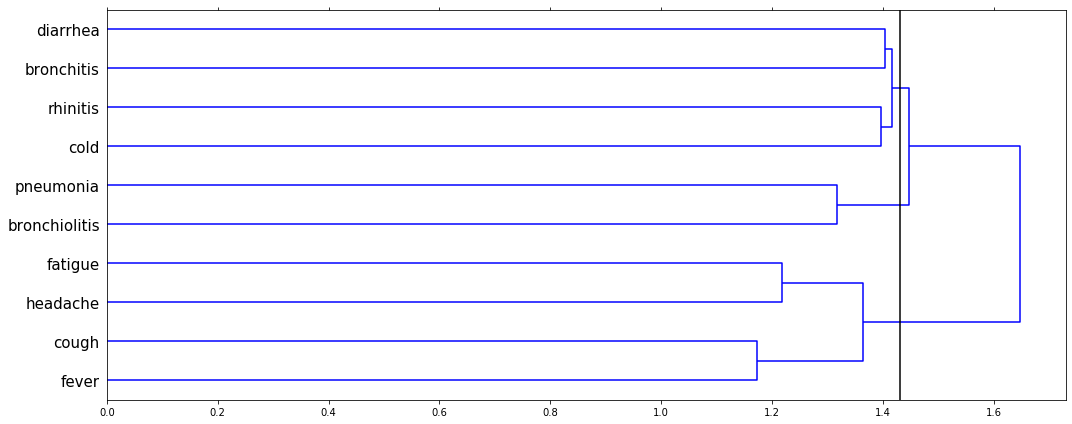

In [16]:
dist2 = pairwise_distances(symp_tfidf.T, metric = 'cosine')

linkage_matrix = ward(dist2) #define the linkage_matrix using ward clustering pre-computed distances
cutoff_line = 1.43

fig, ax = plt.subplots(figsize=(15, 6)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels = tfidf.get_feature_names());
plt.axvline(x=cutoff_line, c='k')
plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.yticks(fontsize = '15')
plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
# plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [17]:
from scipy.cluster.hierarchy import fcluster
clusters = fcluster(linkage_matrix, cutoff_line, criterion='distance')
clusters

array([3, 1, 1, 3, 3, 2, 2, 3, 1, 1], dtype=int32)

In [18]:
skill_label = pd.DataFrame(tfidf.get_feature_names())
cluster_label = pd.DataFrame(clusters)
final_clustered = pd.concat([skill_label, cluster_label], axis = 1)
final_clustered.columns = ['Symptoms', 'Cluster']

In [19]:
final_clustered

,Symptoms,Cluster
0,cold,3
1,fever,1
2,cough,1
3,rhinitis,3
4,bronchitis,3
5,bronchiolitis,2
6,pneumonia,2
7,diarrhea,3
8,headache,1
9,fatigue,1


**The given Dendogram shows how each symptoms are paired together and clustered accordingly. By selecting an appropriate threshold value, we can see that we now have 3 clusters.**

**Cluster 1 represents 'fever', 'cough', 'headache' and 'fatigue'.**

**Cluster 2 represents 'bronchiolitis' and 'pneumonia'.**

**Cluster 3 represents 'rhinitis', 'bronchitis' and 'cold'.**

**Cluster 1 represents symptoms which occur at a very early stage of infection by a coronavirus. From various sources, we know that people diagnosed with COVID-19 had cough and fever as their initial symptoms. Elements in cluster 2 represent medical conditions which occur at a later stage where the virus starts affecting the lungs. These are 'bronchiolitis' and 'pneumonia'. Cluster 3 represents medical conditions like 'rhinitis' and 'bronchitis' which are severe conditions and patients require special care and might also require special medical equipments to help them cure.**

### 3.2 Latent Dirichlet Allocation
**We will use Latent Dirichlet Allocation (LDA) as our unsupervised model which is a topic modeling technique. It is usually used to convert a set of research papers to a set of topics.
Here, we will be using our own list of dictionary, which is the list of symptoms for the coronavirus disease. These are called topics. 
Each document or research paper is represented as a distribution over these topics and each topic is represented as a distribution of the list of words (or topics in our case).**

In [20]:
vocab = [d.split() for d in vocab]

In [21]:
dictionary = corpora.Dictionary(vocab)
# dictionary.save('dictionary.dict')

In [22]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in text_list]
corpora.MmCorpus.serialize('corpus.mm', doc_term_matrix)

In [23]:
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=4, id2word = dictionary, passes=25, random_state=10)

In [24]:
for i in ldamodel.print_topics(num_topics=4, num_words=4): 
    for j in i: print (j)

0
0.696*"diarrhea" + 0.269*"cough" + 0.035*"fatigue" + 0.000*"headache"
1
0.485*"bronchitis" + 0.433*"bronchiolitis" + 0.081*"rhinitis" + 0.000*"cough"
2
0.999*"pneumonia" + 0.000*"fatigue" + 0.000*"cough" + 0.000*"headache"
3
0.747*"fever" + 0.214*"cold" + 0.038*"headache" + 0.000*"cough"


In [25]:
dist = []
for i in range(4):
    dist.append(ldamodel.show_topic(topicid=i, topn=4))
    

In [26]:
dist

[[('diarrhea', 0.6957392),
  ('cough', 0.26898316),
  ('fatigue', 0.034769747),
  ('headache', 7.456971e-05)],
 [('bronchitis', 0.4845035),
  ('bronchiolitis', 0.4333265),
  ('rhinitis', 0.081239365),
  ('cough', 0.0001372743)],
 [('pneumonia', 0.9994041),
  ('fatigue', 6.803228e-05),
  ('cough', 6.744607e-05),
  ('headache', 6.6447e-05)],
 [('fever', 0.74666744),
  ('cold', 0.21430413),
  ('headache', 0.038473476),
  ('cough', 8.223758e-05)]]

The list generated above tells us that each topic contains words from our list of symptoms which are related to each other. 
In the first list, pneumonia and fatigue are related to eatch other according to our research papers. This means that they both are centred around a common aspect. 

In [27]:
pyLDAvis.enable_notebook()

In [28]:
data = pyLDAvis.gensim.prepare(ldamodel, gensim.corpora.MmCorpus('corpus.mm'), dictionary)
data

C:\Users\Hp\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.423219 -0.004082       1        1  30.244436
0     -0.153364 -0.352542       2        1  27.246935
3     -0.148172  0.337673       3        1  25.600784
1     -0.121682  0.018951       4        1  16.907846, topic_info=  Category         Freq           Term        Total  loglift  logprob
6  Default  3599.000000      pneumonia  3599.000000  10.0000  10.0000
1  Default  2276.000000          fever  2276.000000   9.0000   9.0000
7  Default  2257.000000       diarrhea  2257.000000   8.0000   8.0000
4  Default   976.000000     bronchitis   976.000000   7.0000   7.0000
5  Default   873.000000  bronchiolitis   873.000000   6.0000   6.0000
2  Default   873.000000          cough   873.000000   5.0000   5.0000
0  Default   653.000000           cold   653.000000   4.0000   4.0000
3  Default   164.000000       rhinitis   164.000000   3.0000   3.0000
8  Default   118.000000       headache   118.000000   2.0000   2.0000
9  Default   113.000000        fatigue   113.000000   1.0000   1.0000
6   Topic1  3599.057373      pneumonia  3599.799561   1.1957  -0.0006
9   Topic1     0.244998        fatigue   113.560493  -4.9430  -9.5955
8   Topic1     0.239289       headache   118.025276  -5.0051  -9.6191
3   Topic1     0.235173       rhinitis   164.261429  -5.3530  -9.6365
0   Topic1     0.235852           cold   653.997437  -6.7318  -9.6336
2   Topic1     0.242887          cough   873.429626  -6.9917  -9.6042
5   Topic1     0.237749  bronchiolitis   873.089600  -7.0127  -9.6256
4   Topic1     0.235778     bronchitis   976.118103  -7.1326  -9.6339
1   Topic1     0.238929          fever  2276.795410  -7.9663  -9.6206
7   Topic1     0.235387       diarrhea  2257.918701  -7.9729  -9.6355
7   Topic2  2257.180664       diarrhea  2257.918701   1.2999  -0.3628
2   Topic2   872.659729          cough   873.429626   1.2993  -1.3131
9   Topic2   112.803192        fatigue   113.560493   1.2935  -3.3590
8   Topic2     0.241926       headache   118.025276  -4.8898  -9.5038
3   Topic2     0.235000       rhinitis   164.261429  -5.2494  -9.5328
0   Topic2     0.233546           cold   653.997437  -6.6373  -9.5390
5   Topic2     0.233267  bronchiolitis   873.089600  -6.9274  -9.5402
4   Topic2     0.233853     bronchitis   976.118103  -7.0364  -9.5377
1   Topic2     0.236152          fever  2276.795410  -7.8736  -9.5279
6   Topic2     0.234151      pneumonia  3599.799561  -8.3402  -9.5364
1   Topic3  2276.054443          fever  2276.795410   1.3622  -0.2921
0   Topic3   653.259888           cold   653.997437   1.3614  -1.5404
8   Topic3   117.278084       headache   118.025276   1.3562  -3.2578
9   Topic3     0.247881        fatigue   113.560493  -4.7646  -9.4171
3   Topic3     0.238808       rhinitis   164.261429  -5.1710  -9.4544
2   Topic3     0.250684          cough   873.429626  -6.7934  -9.4059
5   Topic3     0.238392  bronchiolitis   873.089600  -6.8433  -9.4562
4   Topic3     0.237973     bronchitis   976.118103  -6.9566  -9.4579
7   Topic3     0.238305       diarrhea  2257.918701  -7.7939  -9.4565
6   Topic3     0.239650      pneumonia  3599.799561  -8.2547  -9.4509
4   Topic4   975.410522     bronchitis   976.118103   1.7767  -0.7246
5   Topic4   872.380188  bronchiolitis   873.089600   1.7766  -0.8363
3   Topic4   163.552444       rhinitis   164.261429   1.7731  -2.5104
9   Topic4     0.264426        fatigue   113.560493  -4.2851  -8.9377
8   Topic4     0.265973       headache   118.025276  -4.3179  -8.9318
0   Topic4     0.268116           cold   653.997437  -6.0220  -8.9238
2   Topic4     0.276363          cough   873.429626  -6.2811  -8.8935
7   Topic4     0.264479       diarrhea  2257.918701  -7.2748  -8.9375
1   Topic4     0.265781          fever  2276.795410  -7.2782  -8.9326
6   Topic4     0.268279      pneumonia  3599.799561  -7.7270  -8.9232, token_table=      Topic      Freq           Term
term         

The above model visualization helps us to interpret the topics in a topic model that has been fit to a corpus of text data. 
The LDA model uses Saliency and Relevance metrics to describe the topics in our dataset. Saliency is a measureof how much the term tells you about the topic while Relevance ia a weighted average of the probability of the word given in the topic and the word given in the topic normalized by the probability of the topic.
So the keywords contribute to the specific topic and the weights tells us how important that keyword is to that topic. 

If you notice, each cluster shows the overall term frequency (shown in blue) and the term frequency within the selected topic (shown in red if a topic/cluster is chosen). The size of the cluster determines the overall relevance of that topic in your entire dataset.  

**From the above 2 models implemented, Hierarchical clustering gives us better clusters when compared to LDA.**

## 4. Insights

COVID-19 is one of the coronaviruses which can be transferred to humans from consumption of wild animals. As it is a novel virus, it is similar to other members of the coronavirus family like SARS and MERS. By looking at them, we found out that the symptoms of COVID-19 also coincide with the other members of its family. These symptoms are 'cold', 'fever', 'cough', 'rhinitis', 'bronchitis', 'bronchiolitis', 'pneumonia', 'diarrhea', 'headache' and 'fatigue'. 
Given thousands of research papers written on coronaviruses, the common thing between all of them are the symptoms. That is why I chose to go with the analysis of symptoms. 

From the above 2 implemented models, Hierarchical clustering gave us promising results in terms of forming clusters with similar features. The similarity was computed by calculating a distance matrix and then a dendogram was formed which gave us a visual representation of the clusters. 
Clusters were formed on the basis of severity of the infection. Cluster 1 gave us symptoms which usually occur in the early stages of infection. Similarly, cluster 2 consists of symptoms which a COVID-19 patient shows at a later stage (like after 10 days). Cluster 3 consists of medical conditions which are fatal to humans and might also lead to death. 

The cluster order gives us a brief insight on what stage the infected person is at and what medical needs is required either in order to cure him, or to provide medical help. These insights would have been useful if this was done at an earlier stage (let's say when this novel virus was first detected) as then, we could predict what medical supplies and medical equipments would be required to cure or help the person in need. 